## Lab 8: Tree Based Methods
Jack Krebsbach Math 313 

Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS

New imports

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

#### Fittting Classification Trees
We will start off using the Cars Seats data set.

In [3]:
# Load Data
Carseats = load_data('Carseats')
# Where Sales are high
High = np.where(Carseats.Sales > 8,
"Yes", "No")

In [4]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

We need to specify to the classifier certain hyperparameters such as ```max_depth``` or ```min_samples_split```.

In [5]:
clf = DTC(criterion='entropy', max_depth=3,
random_state=0) 
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [7]:
accuracy_score(High, clf.predict(X))

0.79

This pretty good, with only the default arguments, the training error rate is only 21%. We can access the value of the deviance using ```log_loss()```.

$-2 \sum_m \sum_k n_{m k} \log \hat{p}_{m k}$,

$n_{mk}$ is the number of observations in the mth terminal node.

In [8]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.4710647062649358

This value is closely related to entropy. A small deviance means the tree generally has good fit to the data.

In [9]:
High

array(['Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No',
       'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes',
       'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No',
       'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes',
       'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes',
       'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes',
       'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No',
       'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'N

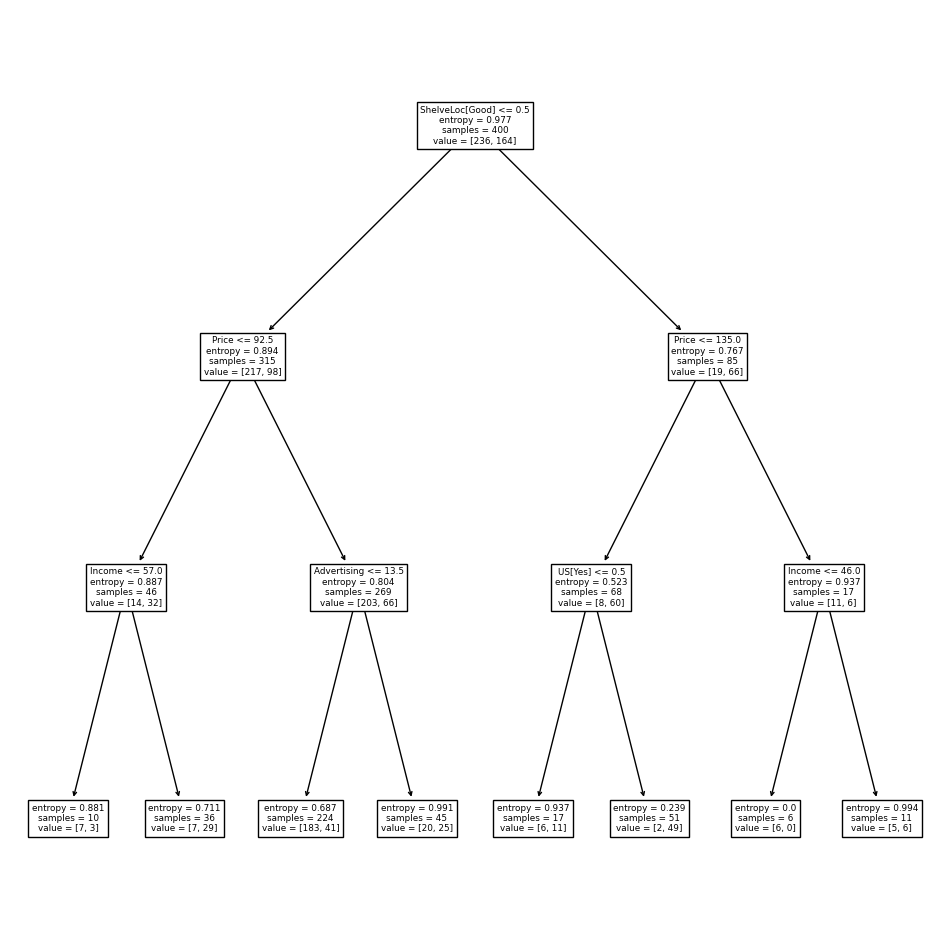

In [13]:
ax = subplots(figsize=(12,12))[1] 
plot_tree(clf,
feature_names=feature_names, ax=ax);

We see that the most relavent predictor for high sales is shelf location.

We can also get a text representation of the tree by 
the following.

We can extract different data about the tree:
- Split Criterion
- Number of observations in each leaf (show_weights=True)

In [14]:
print(export_text(clf, feature_names=feature_names,
show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes


However, to properly evaluate the performance of the classification tree on the data we use a training and testing set.

In [15]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0) 
results = skm.cross_validate(clf, D, High, cv=validation)
results['test_score']

array([0.685])

Now we see if pruning the tree will improve the  performance.

In [21]:
(X_train,
X_test ,
High_train ,
High_test) = skm.train_test_split(X, High , test_size=0.5, random_state=0)

In [22]:
# We do not need to set max_depth because that will be learned through cross validation
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [27]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

In [28]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold, scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

The pruned tree:

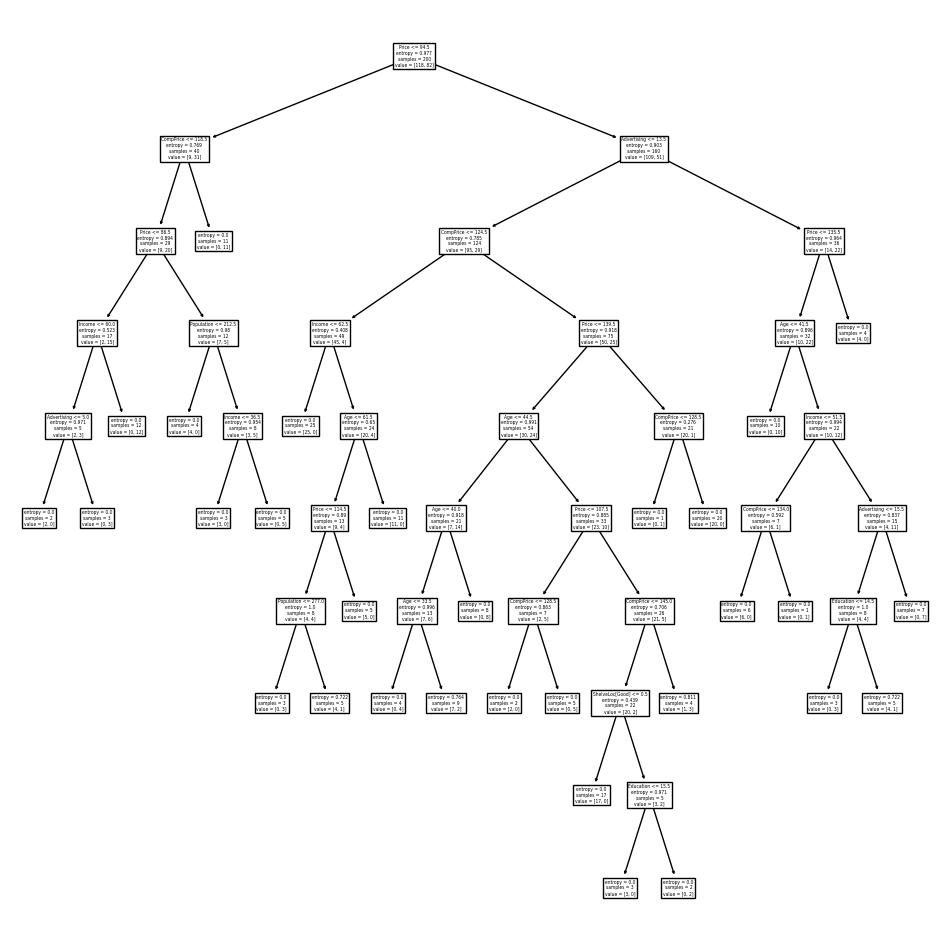

In [30]:
ax = subplots(figsize=(12, 12))[1] 
best_ = grid.best_estimator_
plot_tree(best_,
feature_names=feature_names, ax=ax);

In [31]:
# Count the leaves
best_.tree_.n_leaves

30

Test it on the test data

In [32]:
print(accuracy_score(High_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


#### Fitting Regression Trees
Now we will focus on fitting regression trees to the Boston data.

In [33]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

Use 30% for the test and training set.

In [34]:
(X_train,X_test,
 y_train ,
 y_test) = skm.train_test_split(X,
                                Boston['medv'], test_size=0.3, random_state=0)

Now that we have the training and testing sets we can fit our regression tree.

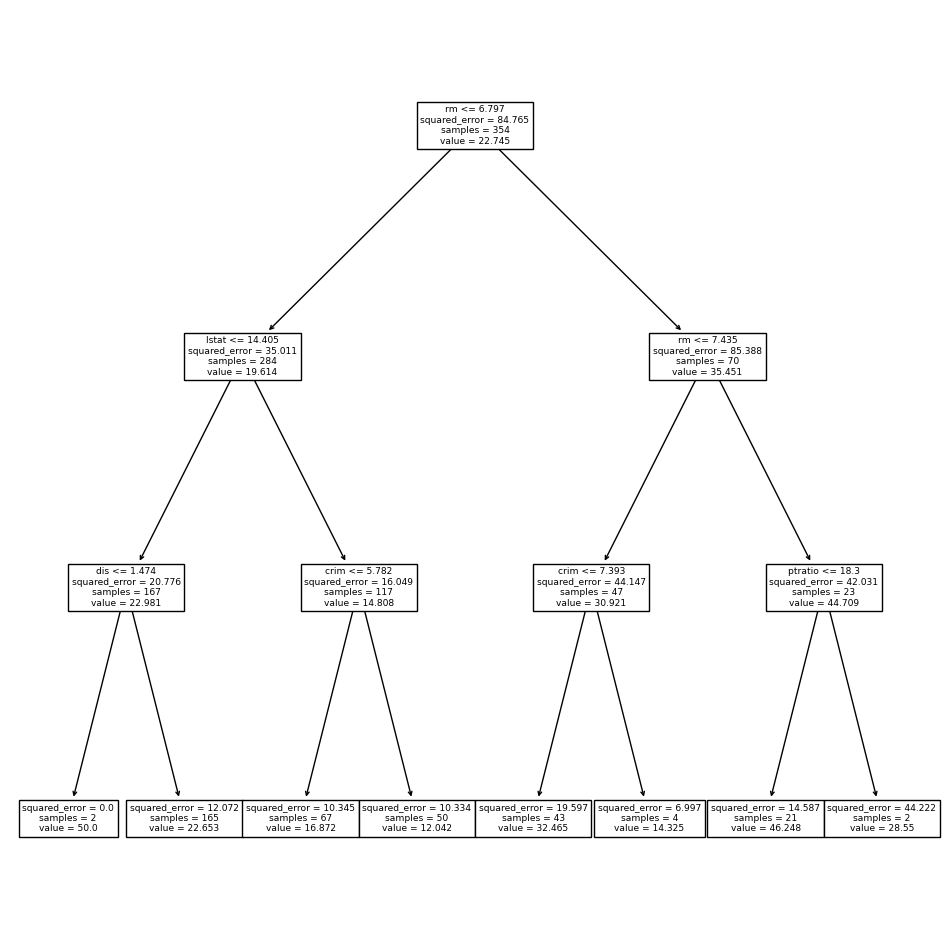

In [35]:
reg = DTR(max_depth=3) 
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1] 
plot_tree(reg,
feature_names=feature_names, ax=ax);

In [36]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
shuffle=True,
random_state=10) 
grid = skm.GridSearchCV(reg,
{'ccp_alpha': ccp_path.ccp_alphas}, refit=True,
cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [37]:
best_= grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

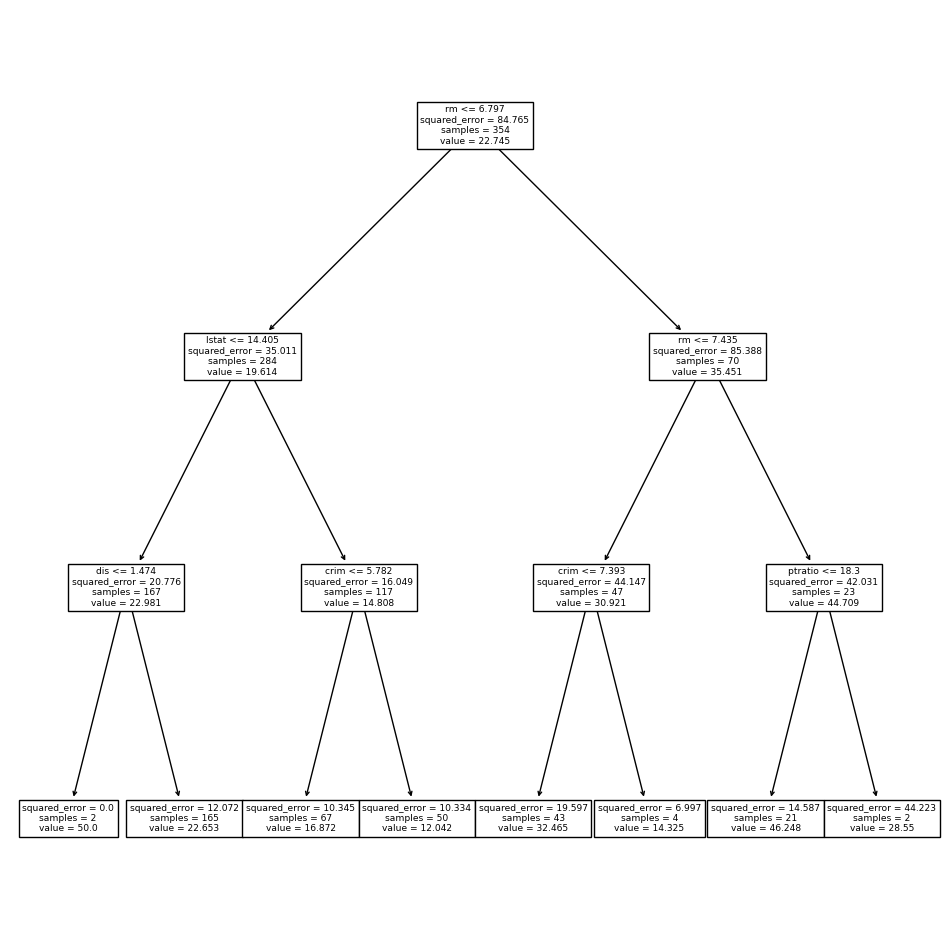

In [38]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_ ,
feature_names=feature_names, ax=ax);

#### Bagging and Random Forests

In [39]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train,y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

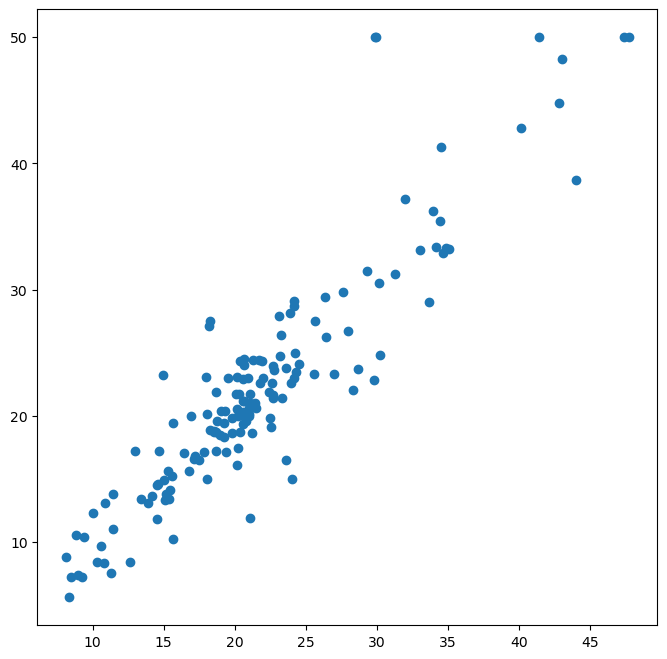

In [41]:
ax = subplots(figsize=(8,8))[1] 
y_hat_bag = bag_boston.predict(X_test) 
ax.scatter(y_hat_bag, y_test) 
np.mean((y_test - y_hat_bag)**2)

In [42]:
bag_boston = RF(max_features=X_train.shape[1], n_estimators=500,
random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161